<a href="https://colab.research.google.com/github/MiraPurkrabek/vs3-cnn-labs/blob/main/Mira_colorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install kornia timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 517 kB 24.9 MB/s 
     |████████████████████████████████| 512 kB 65.4 MB/s 


In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
import kornia as K
import torchvision.transforms as tfms
from tqdm import tqdm_notebook as twdm
from time import time
from fastai.vision.all import *
from fastai.data.all import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# !wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz
# !tar -xzf imagenette2-160.tgz

--2022-07-25 12:10:01--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.42.104
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.42.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99003388 (94M) [application/x-tar]
Saving to: ‘imagenette2-160.tgz’

imagenette2-160.tgz 100%[===================>]  94.42M  13.4MB/s    in 8.6s    

2022-07-25 12:10:10 (10.9 MB/s) - ‘imagenette2-160.tgz’ saved [99003388/99003388]



In [5]:
from kornia.color import rgb_to_grayscale

def label_func_color(x):
    return x

class RGB2GreyTransform(ItemTransform):
    order = 15 # run after IntToFloatTransform
    def encodes(self, o):
        # expand restores tensor shape back to use c channels 
        # (ie. N,c,h,w) instead of N,1,h,w
        img, mask = o
        return rgb_to_grayscale(img[None].float())[0].expand(3,-1,-1), mask
    

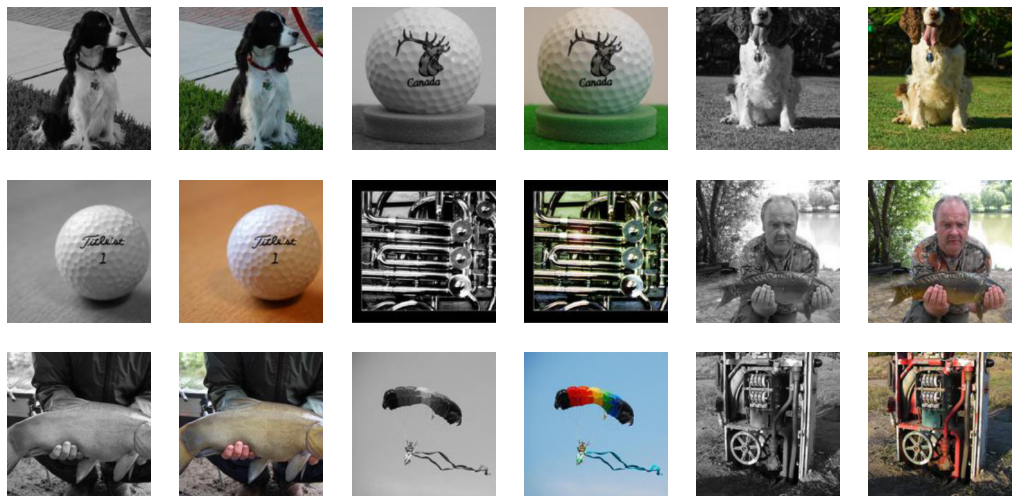

In [6]:
dblock = DataBlock(blocks    = (ImageBlock, ImageBlock),
                   get_items = get_image_files,
                   get_y     = label_func_color,
                   splitter  = RandomSplitter(),
                   item_tfms = [Resize(224), RGB2GreyTransform()])

dsets = dblock.datasets('imagenette2-160/')
dls = dblock.dataloaders("imagenette2-160/", bs=16)
dls.show_batch()

In [7]:
import torchvision as tv
import torch.nn.functional as F


class ContentLoss(nn.Module):
    """"""
    def __init__(self, arch = 'alexnet', layer_id = 11):
        super(ContentLoss, self).__init__()
        # HIDE_IN_TEMPLATE_START
        self.layer_id = layer_id
        if arch == 'alexnet':
            cnn = tv.models.alexnet(True)
        else:
            cnn = tv.models.vgg13_bn(True)
        self.content_cnn =  nn.Sequential(*cnn.features[:layer_id])
        self.content_cnn.eval()
        # HIDE_IN_TEMPLATE_STOP
        return
    def forward(self, input, label):
        with torch.no_grad():
            target_feats = self.content_cnn(label)
        in_feats = self.content_cnn(input)
        loss = F.mse_loss(in_feats, target_feats)
        return loss

In [8]:

import timm
from fastai.vision.models import resnet34

model = timm.create_model('resnet18', pretrained=True)
m = nn.Sequential(*list(model.children())[:-2])
model_color = DynamicUnet(m, 3, (128,128), norm_type=None)

learn = Learner(dls, model_color, loss_func=ContentLoss())



Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [9]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,time
0,0.460854,0.462930,06:58
1,0.402883,0.406898,06:54


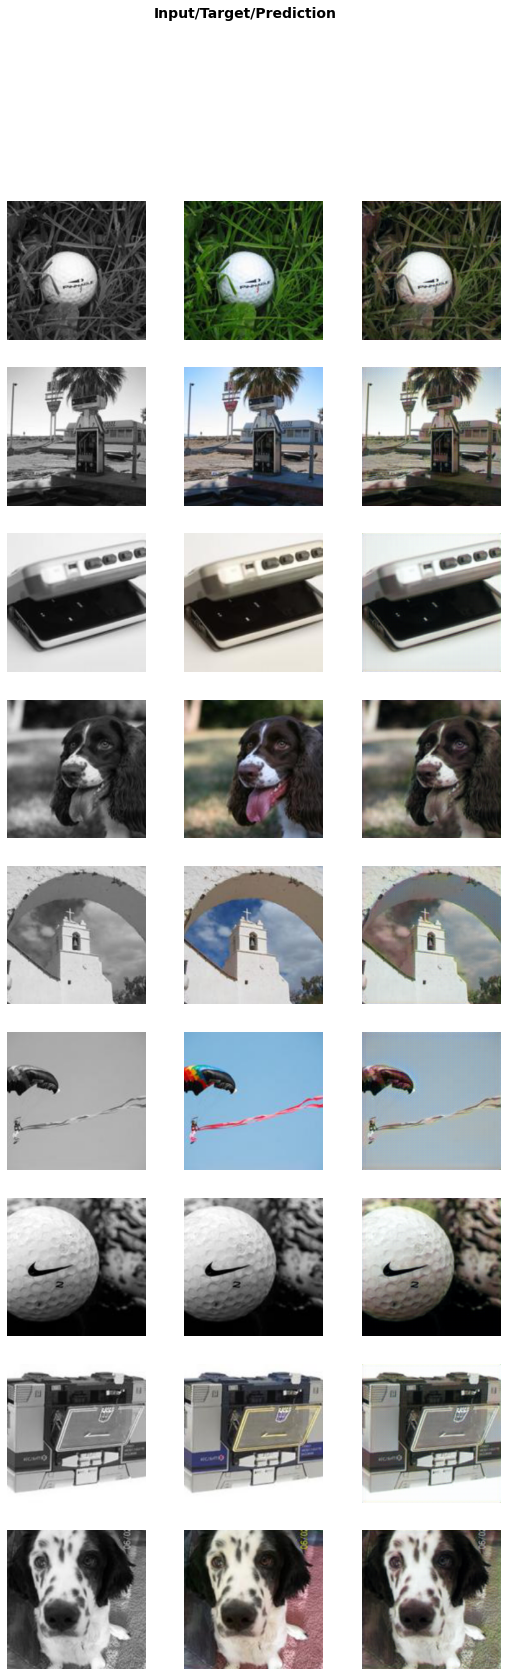

In [10]:
learn.show_results()